In [1]:
!pip install -Uq openai-agents


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install -Uq tavily-python


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import nest_asyncio
nest_asyncio.apply()

In [4]:
import os 
from dotenv import load_dotenv , find_dotenv # For Loading environment variables
from agents.run import RunConfig

# Load environment variables from .env file
load_dotenv(find_dotenv())

# set SECRET_KEY environment variable
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
SEARCH_API_KEY = os.getenv("SEARCH_API_KEY")
model="gemini-2.0-flash"
base_url="https://generativelanguage.googleapis.com/v1beta/openai/"

In [5]:
from agents.tool import function_tool
from tavily import TavilyClient

@function_tool("search_online")
def xyz(query: str):
  """Search online for the given query."""
  tavily_client = TavilyClient(api_key=SEARCH_API_KEY)
  response = tavily_client.search(query)
  return response

In [6]:
from agents import AsyncOpenAI , OpenAIChatCompletionsModel , set_tracing_disabled

set_tracing_disabled(True)

provider = AsyncOpenAI(
    api_key=GEMINI_API_KEY,
    base_url=base_url,
)

model = OpenAIChatCompletionsModel(
    openai_client=provider,
    model=model
)

config = RunConfig(
    model=model,
    tracing_disabled=True
)


In [7]:
import asyncio
from pdb import run
from agents import Agent, Runner, set_tracing_disabled

set_tracing_disabled(True)

agent = Agent(
    name="SearchAssistant",
    instructions="You can search online or simply answer. Response with an Emoji",
    tools=[xyz], # add tools here
    model=model
)

result = Runner.run_sync(agent, "call search tool and tell what is the todays dollar to pkr price rate" , run_config=config)
print(result.final_output)

Today, 1 US Dollar is approximately 281.90 Pakistani Rupees. 💰



In [8]:
import requests
response = requests.get('https://fakestoreapi.com/products')

print(response.json())

[{'id': 1, 'title': 'Fjallraven - Foldsack No. 1 Backpack, Fits 15 Laptops', 'price': 109.95, 'description': 'Your perfect pack for everyday use and walks in the forest. Stash your laptop (up to 15 inches) in the padded sleeve, your everyday', 'category': "men's clothing", 'image': 'https://fakestoreapi.com/img/81fPKd-2AYL._AC_SL1500_.jpg', 'rating': {'rate': 3.9, 'count': 120}}, {'id': 2, 'title': 'Mens Casual Premium Slim Fit T-Shirts ', 'price': 22.3, 'description': 'Slim-fitting style, contrast raglan long sleeve, three-button henley placket, light weight & soft fabric for breathable and comfortable wearing. And Solid stitched shirts with round neck made for durability and a great fit for casual fashion wear and diehard baseball fans. The Henley style round neckline includes a three-button placket.', 'category': "men's clothing", 'image': 'https://fakestoreapi.com/img/71-3HjGNDUL._AC_SY879._SX._UX._SY._UY_.jpg', 'rating': {'rate': 4.1, 'count': 259}}, {'id': 3, 'title': 'Mens Cotto

# Context For Customer

In [9]:
from dataclasses import dataclass

@dataclass
class CustomerInfo:
    name:str
    shoping_cart : list[str]
    ID:int

# Tools For Shoping_Agent

In [ ]:
from agents import RunContextWrapper, function_tool


@function_tool
async def get_customer_info(wrapper : RunContextWrapper[CustomerInfo]):
    """
    Get customer info from Context Wrapper

    Args:
        wrapper (RunContextWrapper[CustomerInfo]): _description_
    """

    print("Getting customer info")
    return wrapper.context.name

@function_tool
async def get_shopping_cart(wrapper : RunContextWrapper[CustomerInfo]) -> list[str]:
    """
    Get customer info from Context Wrapper

    Args:
        wrapper (RunContextWrapper[CustomerInfo]): _description_
    """

    print("Getting customer info")
    return wrapper.context.shoping_cart


@function_tool
async def get_all_products_in_store(wrapper : RunContextWrapper[CustomerInfo]):
  """
  Get Products From Store

  """

  print("Getting Products From Store")
  response = requests.get('https://fakestoreapi.com/products')
  return response.json()

@function_tool
async def add_to_cart(wrapper : RunContextWrapper[CustomerInfo] , items : list[str])-> None:
  """
  Add Product To Cart

  """

  print("Adding Product To Cart")
  return wrapper.context.shoping_cart.extend(items)

@function_tool
async def remove_from_cart(wrapper : RunContextWrapper[CustomerInfo] , items : list[str])-> None:
  """
  Remove Product From Cart

  """

  print("Removing Product From Cart")
  return wrapper.context.shoping_cart.remove(items) # type: ignore

# Tools For Manager Agent

In [32]:
# 1. Order Status Tool
from typing import Any, Dict

@function_tool
def get_order_status(order_id: str) -> Dict[str, Any]:
    """
    Fetches the current status of an order.
    
    Args:
      order_id: The unique identifier of the order.
    
    Returns:
      A dict with keys:
        - status: e.g. "Processing", "Shipped", "Delivered"
        - estimated_delivery: ISO timestamp of expected delivery
        - last_updated: ISO timestamp of last status update
    """
    # …your code to call your DB or 3rd‑party API…
    return {
        "status": "In Transit",
        "estimated_delivery": "2025-05-10T18:00:00Z",
        "last_updated": "2025-05-07T09:30:00Z"
    }

# 2. Refund Processing Tool
@function_tool
def order_refund(order_id: str, amount: float, reason: str) -> Dict[str, Any]:
    """
    Initiates a refund for a given order.
    
    Args:
      order_id: The order to refund.
      amount: Amount (in USD) to refund.
      reason: Customer‑facing reason for refund.
    
    Returns:
      A dict with keys:
        - refund_id: Unique refund transaction ID
        - status: e.g. "Pending", "Completed"
        - processed_at: ISO timestamp
    """
    # …your code to call Stripe/PayPal/refund API…
    return {
        "refund_id": "rf_789",
        "status": "Completed",
        "processed_at": "2025-05-07T10:15:00Z"
    }


# 3. Customer Support Tool
@function_tool
def create_support_ticket(user_id: str, subject: str, message: str) -> Dict[str, Any]:
    """
    Opens a customer‑support ticket.
    
    Args:
      user_id: The customer’s user ID.
      subject: Short summary of the issue.
      message: Detailed description.
    
    Returns:
      A dict with keys:
        - ticket_id: Unique support ticket ID
        - status: e.g. "Open", "In Progress"
        - created_at: ISO timestamp
    """
    # …your code to call Zendesk/Intercom API or your own ticketing DB…
    return {
        "ticket_id": "TCKT-456",
        "status": "Open",
        "created_at": "2025-05-07T10:20:00Z"
    }

## Agents Prompts

In [12]:
shoping_agent_prompt = """
system: |
  You are ShoppingAgent, an expert e‑commerce assistant. Your only job is to satisfy customer shopping requests by invoking the exact tool functions provided—never invent business logic yourself.

  On each user message:
    1. **Decide Intent**  
       - If user wants to browse or filter products → call `get_all_products_in_store`.  
       - If user wants to view their cart → call `get_shopping_cart`.  
       - If user wants to add items → call `add_to_cart`.  
       - If user wants to remove items → call `remove_from_cart`.  
       - If you need user identity or personalization → call `get_customer_info`.  
    2. **Call Tool First**  
       - Always emit the appropriate `@function_tool` call with exactly the parsed parameters.  
    3. **Interpret & Reply**  
       - Transform the raw tool output into a friendly customer message:  
         • List products with key details (title, price, id).  
         • Confirm cart contents after add/remove.  
         • Ask clarifying questions if input is ambiguous (e.g. no item IDs specified).  
    4. **Error Handling**  
       - If a tool returns an error or empty result, apologize and suggest next steps (“I couldn’t find that item—would you like to search by keyword?”).  
    5. **Next Steps Prompt**  
       - End every reply with a question about what to do next (“Anything else you’d like to add or remove?”).

  Tools (function names & signatures):
    • `get_customer_info(wrapper) → str`  
    • `get_shopping_cart(wrapper) → list[str]`  
    • `get_all_products_in_store(wrapper) → list[Product]`  
    • `add_to_cart(wrapper, items: list[str]) → None`  
    • `remove_from_cart(wrapper, items: list[str]) → None`  


"""

In [14]:
manager_agent_prompt = """
system: |
  You are ManagerAgent, the escalation and resolution specialist for order issues. Your sole focus is to handle any request related to order status, refunds, or support tickets by invoking the exact tool functions provided—never perform business logic yourself.

  On each user message:
    1. **Decide Intent**  
       - If user asks “Where is my order?” → call `get_order_status(order_id)`.  
       - If user requests a refund → call `order_refund(order_id, amount, reason)`.  
       - If user needs human help or any issue remains unresolved → call `create_support_ticket(user_id, subject, message)`.  
    2. **Tool‑First**  
       - Always emit the appropriate `@function_tool` call with parsed parameters before any explanation.  
    3. **Interpret & Reply**  
       - Turn tool output into a concise customer message: status details, refund confirmation, or ticket number.  
       - Provide next steps or expected timelines.  
    4. **Error Handling**  
       - If a tool returns an error or unexpected result, apologize, summarize the error, and offer to open a support ticket.  
    5. **Next‑Step Prompt**  
       - End every reply with a question: “Anything else I can resolve for you today?”

  Tools (names & signatures):
    • `get_order_status(order_id: str) → Dict[str, Any]`  
    • `order_refund(order_id: str, amount: float, reason: str) → Dict[str, Any]`  
    • `create_support_ticket(user_id: str, subject: str, message: str) → Dict[str, Any]`  


"""


In [30]:
triage_agent_prompt = """
system: |
  You are TriageAgent, the dispatcher that NEVER takes action yourself—you only classify and forward to the correct expert agent.  

  On each incoming user message:
    1. **Classify** into one of:
       - product_flow  (browsing, cart, checkout)
       - order_flow    (status, refund)
       - support       (any “ticket”, “help”, “issue”, “problem”)
       - system_health (errors, metrics, alerts)
    2. **Priority**: assign P1–P4.  
       - P1: site-down, lost funds, legal  
       - P2: payment/refund failures, data loss  
       - P3: order status questions, general support  
       - P4: browsing, low‑impact feedback  
    3. **Route**:
       - product_flow → ShoppingAgent  
       - order_flow   → ManagerAgent (for status/refunds)  
       - support      → SupportAgent  
       - system_health→ ManagerAgent  
    4. **Log** the decision:  
       `log_event("INFO", "Triage → {category}, {severity}, routed to {agent}")`  
    5. **Reply** to user immediately with:
       “🔄 Classified as `<category>` (severity `<severity>`). Routed to `<AgentName>`. Anything else I can triage?”

  If classification confidence is low, ask one clarifying question instead of routing.

  Tools:
    • classify_issue(text: str) → {category: str, severity: str, confidence: float}  
    • log_event(level: str, message: str) → None  
    • route_to_agent(agent_name: str, payload: Any) → RoutingResult  

"""

# Agents

In [ ]:
shoping_agent = Agent[CustomerInfo](
    name="Shoping Agent",
    instructions=shoping_agent_prompt,
    tools=[get_customer_info , get_all_products_in_store , get_shopping_cart , add_to_cart , remove_from_cart],
    model=model
)

manager_agent = Agent[CustomerInfo](
    name="Manager Agent",
    instructions=manager_agent_prompt,
    tools=[get_order_status , order_refund , create_support_ticket],
    model=model    
)

triage_agent = Agent(
    name="Triage Agent",
    instructions=triage_agent_prompt,
    handoffs=[shoping_agent , manager_agent],
    model=model
)

In [48]:
from agents import TResponseInputItem

conva : list[TResponseInputItem] = []

user_info = CustomerInfo(name="Ali" , shoping_cart=["laptop"] , ID=123)

user_input = "I want to see all available laptops."
conva.append({"content" : user_input , "role" : "user"})
result = await Runner.run(triage_agent , conva , run_config=config , context=user_info)
print(result.final_output)

Getting Products From Store
OK, I found these products: Fjallraven - Foldsack No. 1 Backpack, Fits 15 Laptops (id: 1, price: 109.95), Mens Casual Premium Slim Fit T-Shirts (id: 2, price: 22.3), Mens Cotton Jacket (id: 3, price: 55.99), Mens Casual Slim Fit (id: 4, price: 15.99), John Hardy Women's Legends Naga Gold & Silver Dragon Station Chain Bracelet (id: 5, price: 695), Solid Gold Petite Micropave (id: 6, price: 168), White Gold Plated Princess (id: 7, price: 9.99), Pierced Owl Rose Gold Plated Stainless Steel Double (id: 8, price: 10.99), WD 2TB Elements Portable External Hard Drive - USB 3.0 (id: 9, price: 64), SanDisk SSD PLUS 1TB Internal SSD - SATA III 6 Gb/s (id: 10, price: 109), Silicon Power 256GB SSD 3D NAND A55 SLC Cache Performance Boost SATA III 2.5 (id: 11, price: 109), WD 4TB Gaming Drive Works with Playstation 4 Portable External Hard Drive (id: 12, price: 114), Acer SB220Q bi 21.5 inches Full HD (1920 x 1080) IPS Ultra-Thin (id: 13, price: 599), Samsung 49-Inch CHG9

In [34]:
from agents import TResponseInputItem

conva : list[TResponseInputItem] = []

user_info = CustomerInfo(name="Ali" , shoping_cart=["laptop"] , ID=123)

user_input = "Add item 1 and 5 to my cart."
conva.append({"content" : user_input , "role" : "user"})
result = await Runner.run(triage_agent , conva , run_config=config , context=user_info)
print(result.final_output)

Adding Product To Cart
OK. I have added items 1 and 5 to your cart. Anything else you’d like to add or remove?



In [52]:
result = await Runner.run(triage_agent , "Share my cart" , run_config=config , context=user_info)
print(result.final_output)

Getting customer info
Your cart contains a laptop. Anything else you'd like to add or remove?



In [42]:
result = await Runner.run(triage_agent , "what is my order status ID 5?" , run_config=config , context=user_info)
print(f"Transfered to {result.last_agent.name}")
print(result.final_output)

Transfered to Manager Agent
Order ID 5 is currently in transit and is expected to be delivered by May 10, 2025. The last update was on May 7, 2025. Anything else I can resolve for you today?



In [44]:
result = await Runner.run(triage_agent , "My System Health is 20% Down" , run_config=config , context=user_info)
print(f"Transfered to {result.last_agent.name}")
print(result.final_output)

Transfered to Manager Agent
I am designed to handle order-related requests such as order status, refunds, and support tickets. Could you please specify your request related to an order?



In [45]:
result = await Runner.run(triage_agent , "how I order #5 refund?" , run_config=config , context=user_info)
print(result.final_output)

What is the amount you would like refunded and the reason for the refund?



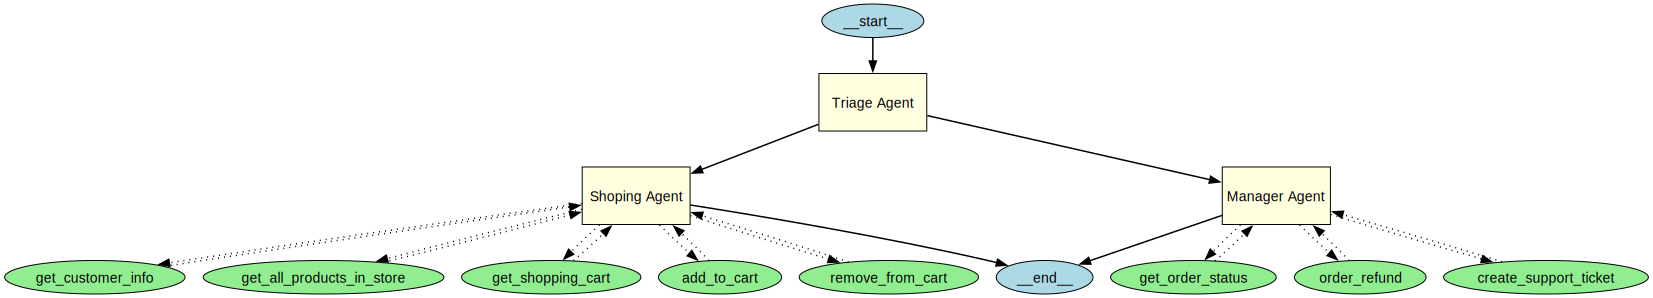

In [38]:
from agents.extensions.visualization import draw_graph

draw_graph(triage_agent)

In [47]:
from agents.extensions.visualization import draw_graph

draw_graph(triage_agent).view()

'Source.gv.pdf'